In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from pathlib import Path
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from demo import *
from models.with_mobilenet import PoseEstimationWithMobileNet, PoseClassificationWithMobileNet
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [2]:
class CustomDataset(Dataset):
    def __init__(self, transform=None) -> None:
        super().__init__()
        self.transform = transform
        self.data_list, self.labels = self.load_data()

    def load_data(self):
        data_list, labels = [], []
        paths = Path('./data/lying_pictures/').glob('*.jpg')
        for path in paths:
            data_list.append(str(path))
            labels.append(1)
        df = pd.read_csv('./data/mpii/mpii_human_pose.csv')
        df = df.loc[(df['Category'] == 'miscellaneous') & (df['Activity'] == 'standing, miscellaneous')]
        file_names = [name for name in df['NAME']]
        parent = Path('./data/mpii/mpii_human_pose_v1/images/')
        for file_name in file_names:
            path = parent / file_name
            data_list.append(str(path))
            labels.append(0)
        return data_list, labels
    
    def __getitem__(self, index):
        image = cv2.imread(self.data_list[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = self.transform(image)
        return image, self.labels[index]
    
    def __len__(self):
        return len(self.data_list)

In [3]:
pretrained = PoseEstimationWithMobileNet()
checkpoint = torch.load('./weights/checkpoint_iter_370000.pth', map_location='cpu')
load_state(pretrained, checkpoint)
net = PoseClassificationWithMobileNet(pretrained)

In [4]:
images = [path for path in Path('./data/lying_pictures/').glob('*.jpg')]
frame_provider = ImageReader(images)

In [5]:
net = net.eval()
if torch.cuda.is_available():
    net = net.cuda()
elif torch.backends.mps.is_available():
    net = net.to('mps')

In [6]:
transform = transforms.Compose([
    transforms.Resize(size=(128, 128), antialias=True),
    transforms.RandomApply([
        # transforms.RandomResizedCrop((128, 128), scale=(0.9, 1.1), ratio=(0.9, 1.1), antialias=True), 
        transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
    ], p=0.3),
    # transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [7]:
dataset = CustomDataset(transform)
trainlen = int(len(dataset) * 0.8)
testlen = len(dataset) - trainlen
train_dataset, test_dataset = random_split(dataset, [trainlen, testlen])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [8]:
optimizer = torch.optim.AdamW(net.classifier.parameters(), lr=0.001, betas=(0.5, 0.999))
loss_func = torch.nn.BCEWithLogitsLoss()

for e in range(5):
    loss_avg, acc = 0, 0
    print(f'epoch : {e+1}')
    for idx, batch in enumerate(tqdm(train_dataloader)):
        images, labels = batch
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.float().cuda()
        elif torch.backends.mps.is_available():
            images = images.to('mps')
            labels = labels.float().to('mps')

        pred = net(images)
        optimizer.zero_grad()
        loss = loss_func(pred.squeeze(), labels)
        loss.backward()
        optimizer.step()

        loss_avg += loss.cpu().detach().item()
        acc += ((torch.nn.functional.sigmoid(pred.squeeze()) > 0.5) == labels.squeeze()).float().mean().item()

    print('train loss :', loss_avg / (idx+1))
    print('train acc :', acc*100 / (idx+1) )

    loss_avg, acc = 0, 0
    for idx, batch in enumerate(tqdm(test_dataloader)):
        images, labels = batch
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.float().cuda()
        elif torch.backends.mps.is_available():
            images = images.to('mps')
            labels = labels.float().to('mps')

        pred = net(images)
        loss = loss_func(pred.squeeze(), labels)

        loss_avg += loss.cpu().detach().item()
        acc += ((torch.nn.functional.sigmoid(pred.squeeze()) > 0.5) == labels.squeeze()).float().mean().item()

    print('test loss :', loss_avg / (idx+1))
    print('test acc :', acc*100 / (idx+1))

epoch : 1


100%|██████████| 34/34 [00:20<00:00,  1.66it/s]


train loss : 0.6862555058563456
train acc : 46.16596646168653


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


test loss : 3.4194459915161133
test acc : 38.888888888888886
epoch : 2


100%|██████████| 34/34 [00:19<00:00,  1.74it/s]


train loss : 0.6814448544207741
train acc : 65.5987395959742


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


test loss : 0.5377505752775404
test acc : 76.38888888888889
epoch : 3


100%|██████████| 34/34 [00:19<00:00,  1.74it/s]


train loss : 0.5329660685623393
train acc : 74.05462194891537


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


test loss : 0.6809880071216159
test acc : 38.888888888888886
epoch : 4


100%|██████████| 34/34 [00:19<00:00,  1.73it/s]


train loss : 0.5333481417859302
train acc : 74.26470588235294


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


test loss : 0.48605496022436356
test acc : 77.77777777777777
epoch : 5


100%|██████████| 34/34 [00:19<00:00,  1.74it/s]


train loss : 0.5708388966672561
train acc : 63.13025215092827


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

test loss : 0.44336925943692523
test acc : 77.77777777777777


In [19]:
sd = net.state_dict()
del_list = []
for key in list(sd.keys()):
    if 'pretrained' in key:
        # print(key)
        sd.pop(key)

In [24]:
with open('test.pt', 'wb') as f:
    torch.save({'state_dict': sd}, f)

In [28]:
cp = torch.load('./test.pt')
load_state(net, cp)

In [117]:
images, labels = next(iter(train_dataloader))

In [118]:
images_mps = images.to('mps')
result = net(images_mps)
result = (torch.nn.functional.sigmoid(result.squeeze()) > 0.5).cpu().numpy() * 1

In [120]:
net(images_mps), result

(tensor([[ 0.9764],
         [-3.8673],
         [ 0.9746],
         [-0.1102],
         [-5.5479],
         [ 0.9580],
         [ 0.9643],
         [ 0.9600]], device='mps:0', grad_fn=<LinearBackward0>),
 array([1, 0, 1, 0, 0, 1, 1, 1]))

In [110]:
images = images.permute(0, 2, 3, 1).numpy()
labels = labels.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


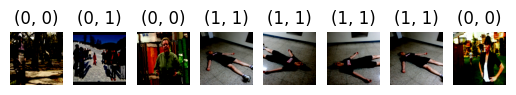

In [111]:
for i, image in enumerate(images):
    plt.subplot(4, 8, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(f'{labels[i], result[i]}')

In [13]:
net = PoseEstimationWithMobileNet()
img = cv2.imread('./data/lying_pictures/0.jpg', cv2.IMREAD_COLOR)
scale = 0.06349206349206349
height_size = 256
stride = 8
scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
scaled_img = normalize(scaled_img, np.array([128, 128, 128], np.float32), np.float32(1/256))
min_dims = [height_size, max(scaled_img.shape[1], height_size)]
padded_img, pad = pad_width(scaled_img, stride, (0, 0, 0), min_dims)
padded_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)
padded_img = cv2.resize(padded_img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
tensor_img = torch.from_numpy(padded_img).permute(2, 0, 1).unsqueeze(0).float()
# tensor_img = tensor_img.cuda()
result = net(tensor_img)

In [ ]:
a, b = result[-1].view(1, -1), result[-2].view(1, -1)
torch.cat([a, b], dim=1).shape

torch.Size([1, 14592])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


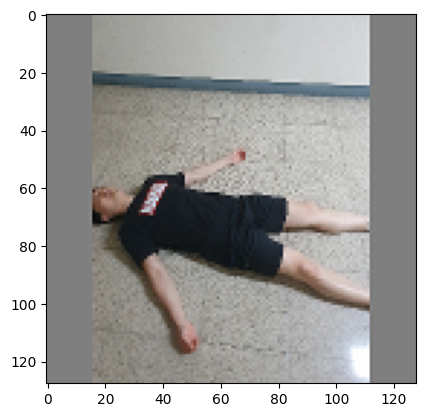

In [ ]:
scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
scaled_img = normalize(scaled_img, np.array([128, 128, 128], np.float32), np.float32(1/256))
min_dims = [height_size, max(scaled_img.shape[1], height_size)]
padded_img, pad = pad_width(scaled_img, stride, (0, 0, 0), min_dims)
padded_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)
padded_img = cv2.resize(padded_img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
plt.imshow(padded_img + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


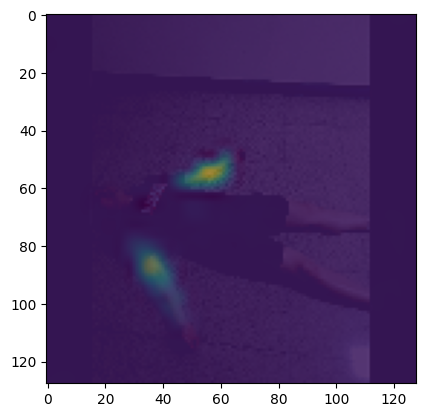

In [ ]:
plt.imshow(padded_img)
plt.imshow(heatmaps[:,:,6], alpha=0.5)
plt.imshow(pafs[:,:,16], alpha=0.5)
plt.show()

In [122]:
import torch

In [124]:
torch.BoolTensor([True]).item()

True